# 2DSegmentNet-v3
* Make sure SegmentNet support multiple inputs too

## Initialization

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Model definition

## Segment Model

In [3]:
class Segment(nn.Module):
    r"""Divides incoming data into segment_features then applies two point
    formula to each segment.
    For any given x only one segment calculates y all others are masked out.
    All in_features (x) contributes in calculation of ever out_feature (y)
    but each combination of in_feature and out out_feature has its own
    set of segments. This will create total number of
    parameters = out_features*in_features*(segment_features + 1)
    
        :math:`y = (y2 - y1)/(x2 - x1)*(x - x1) + y1`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        segment_features: number of segments on x dimensions

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
        dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
        are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        x: the learnable x of the module of shape
            :math:`(\text{in\_features})`, \text{segment\_features + 1}, 
                    \text{out\_features})`.
            The values are
            initialized from :math:`(x.min(), x.max())` and intermediate
            x are linearly spaced.

    Examples::

        >>> m = Segment(20, 30, 10)
        >>> input = torch.randn(128, 20)
        >>> m.custom_init(x.min, x.max)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features', 'segment_features']
    in_features: int
    out_features: int
    segment_features: int
    x: torch.Tensor
    y: torch.Tensor
    def __init__(self, in_features, out_features, segment_features):
        super(Segment, self).__init__()
        self.segment_features = segment_features
        self.out_features = out_features
        self.in_features = in_features

        self.x = nn.Parameter(torch.Tensor(in_features,
                                            segment_features + 1, out_features))
        self.y = nn.Parameter(torch.Tensor(in_features,
                                            segment_features + 1, out_features))
        self.initialized = False

    def custom_init(self, x_min, x_max):
        x_init = torch.empty_like(self.x)
        for i in np.arange(self.in_features):
            for j in np.arange(self.out_features):
                x_init[i, :, j] = torch.linspace(x_min[i], x_max[i],
                                    self.segment_features + 1)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_init))
    
    def _calc_mask(self, x_in):
        # x_in.shape = [N, in_features]
        self.x_in_4d =  x_in.unsqueeze(-1).unsqueeze(-1)     
        # x_in_4d.shape =  [N, in_features, 1, 1] 
        # to find out if x is between segments
        lt = torch.lt(self.x_in_4d, self.x[:, 1:, :]) 
        ge = torch.ge(self.x_in_4d, self.x[:, :-1, :]) 
        self.mask = (lt & ge)
        #mask.shape = [N, in_features, segment_features, out_features]

        # This mask doesn't include x where x is below 1st segment start
        # or after last segment end
        # we create new mask to capture the x values beyond segments
        mask_lt = torch.lt(self.x_in_4d,self.x[:, 0:1, :]) #x less than 1st segment
        # then do OR with mask so these are included for prediction.
        self.mask[:,:, 0:1, :] = self.mask[:, :, 0:1, :] | mask_lt

        #do the same for last x of segment
        mask_ge = torch.ge(self.x_in_4d,self.x[:, -1:, :]) 
        self.mask[:,:, -1:, :] = self.mask[:, :, -1:, :] | mask_ge

    def forward(self, x_in):
        self._calc_mask(x_in)

        divider = (self.x[:,1:,:]-self.x[:,:-1,:])
        #The ratio can get -inf or inf. we need to protect against it
        divider[divider == 0.] = 0.0001

        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        ratio = (self.y[:,1:,:]-self.y[:,:-1,:])/divider

        ypred = ratio*self.mask*(self.x_in_4d - self.x[:,:-1,:]) + self.mask * self.y[:,:-1,:]
        # ypred.shape = [N, in_features, segment_features, out_features]
        # we can sum up by in_features (as y is cumulative of all f(x))
        # and sum by segment_features (only one segment should be non zero)
        ypred = torch.sum(ypred, dim=(1,2))
        return ypred
            
    def extra_repr(self) -> str:
        return f'out_features={self.out_features}, segment_features={self.segment_features}'

# Data Loaders

In [9]:
from torch.utils.data.dataloader import DataLoader

class InfiniteRandomDataLoader:

    def __init__(self, dataset, loss, replacement=True, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


# Functions we are trying to approximate

In [65]:
np.random.seed(10)

# y = ax^4 + bx^3 + cx^2 + dx + f
#input x=1D output y=1D
def f_quartic(x):
    a = -0.019516
    b = 1.1
    c = -.8
    d = 0.5
    f = -5.73434
    return a*x**4 + b*x**3 + c*x +f

def f_quartic2(x):
    a = 0.1
    b = 0.05
    c = -.063398
    d = -.107
    return a*x**4 + b*x**3 + c*x**1 + d

#input x=1D output y=2D
def f2_quartic(x):
    y = np.zeros([2,x.shape[0]])
    y[0] = f_quartic(x)
    y[1] = f_quartic(x+1)
    return y.T

#input x=3D output y=2D
def f32_quartic(x):
    tmp1 = f_quartic(x)
    tmp1 = np.sum(tmp1, axis=1)
    tmp2 = f_quartic2(x)
    tmp2 = np.sum(tmp2, axis=1)
    print(tmp1.shape, tmp2.shape)
    y = np.stack([tmp1, tmp2], axis=1)
    return y


def normalize(x,y):
    x_normalized = torch.nn.functional.normalize(x, dim=0)
    y_normalized = torch.nn.functional.normalize(y, dim=0)

    return x_normalized, y_normalized

# Create dataset

In [66]:
#create ys data from scratch so we can sort xs as needed - made no different with randomloader for segmentnet
f = f32_quartic # select data function
xs1 = np.linspace(-15, 11, 250)
xs2 = np.linspace(3, 11., 250)
xs3 = np.linspace(-5, 5., 250)
xs = np.stack([xs1, xs2, xs3], axis=1) #We want to stack by column (250,3)
ys = f(xs)
x = torch.tensor((xs), dtype=torch.float32)
ytest = torch.tensor((ys), dtype=torch.float32)

#normalization - important
x, ytest = normalize(x, ytest)
print(x.shape, x.min(dim=0), x.max(dim=0)) #250,3
print(ytest.shape, ytest.min(dim=0), ytest.max(dim=0)) # 250,2

(250,) (250,)
torch.Size([250, 3]) torch.return_types.min(
values=tensor([-0.1217,  0.0257, -0.1091]),
indices=tensor([0, 0, 0])) torch.return_types.max(
values=tensor([0.0892, 0.0943, 0.1091]),
indices=tensor([249, 249, 249]))
torch.Size([250, 2]) torch.return_types.min(
values=tensor([-0.1947,  0.0080]),
indices=tensor([  0, 101])) torch.return_types.max(
values=tensor([0.0986, 0.1995]),
indices=tensor([249,   0]))


# Init

In [68]:
# init training
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

torch.manual_seed(10)

model = Segment(x.shape[1], ytest.shape[1], 5)


#Initialize model parameters - extremely important.
model.custom_init(x.min(dim=0).values, x.max(dim=0).values)

# Capture params after initialization
model_params = []
model_params.append(copy.deepcopy(model.state_dict()))

dataLoader = InfiniteRandomDataLoader
# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x, ytest)
criterion = nn.MSELoss(reduction='sum')

#initialize training params
step = 0
losses = np.array([])
with torch.no_grad():
    y = model(x)
    total_mean_loss = criterion(y, ytest)

lr=.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=.5, patience=100,threshold=0.1, threshold_mode='rel', cooldown=0, 
#                                                 min_lr=0, eps=1e-08, verbose=True) # let us try scheduler to reduce learning rate

## Training loop

In [69]:
# training loop

max_steps = 2000
best_val_loss = 100
early_stop_patience = 3 # Stop training loop if val_los > best_val_loss this many times

model.train() # We use this variable for training
# init dataloader
batch_loader = dataLoader(dataset,loss=total_mean_loss,replacement=False, batch_size=64, pin_memory=True, num_workers=1)

while True:
    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X, Y = batch_loader.next()
    #check for NaN
    if math.isnan(Y.mean()):
        print ("Breaking for NaN")
        break

    # Forward pass
    ypred = model(X)
    # Calculate the loss
    loss = criterion(ypred, Y)
    
    # Backward and optimize
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Validate model after this optimizer.step
    # we validate on complete data
    with torch.no_grad():
        y = model(x)
        #y = y.squeeze(2) ### TEMPORARY
        total_mean_loss = criterion(y, ytest)
    losses = np.append(losses, total_mean_loss)

    optimizer.step() #Definitely needed
    step += 1
    #scheduler.step(total_mean_loss)
    t1 = time.time()

    # store params (weights and biases) after each training step
    if step % 10 == 0:
        model_params.append(copy.deepcopy(model.state_dict()))
        #model_param_grads.append(get_model_param_grad(model))
             
    # print logging
    if step % 100 == 0:         
        print(f"step {step} | loss {loss:.4f} | total_mean_loss {total_mean_loss:.4f} | step time {(t1-t0)*1000:.2f}ms")

    # termination conditions
    if total_mean_loss < best_val_loss:
        early_stop_patience = 1000 # max value
        best_val_loss = total_mean_loss
    else:
        early_stop_patience -= 1
        if early_stop_patience == 0 or best_val_loss <= .0022:
            print("Can terminating due to early_stop_patience at step ",step, " best_val_loss:",best_val_loss)
            #break
        
    if step >= max_steps:
        break

print("best_val_loss:",best_val_loss,"last_total_loss:",total_mean_loss, "early_stop_patience:",early_stop_patience," step:",step)

step 100 | loss 0.2721 | total_mean_loss 1.0695 | step time 1.33ms
step 200 | loss 0.1835 | total_mean_loss 0.5994 | step time 1.24ms
step 300 | loss 0.0408 | total_mean_loss 0.3362 | step time 1.50ms
step 400 | loss 0.0745 | total_mean_loss 0.1883 | step time 1.19ms
step 500 | loss 0.0585 | total_mean_loss 0.1085 | step time 1.38ms
step 600 | loss 0.0017 | total_mean_loss 0.0651 | step time 4.07ms
step 700 | loss 0.0187 | total_mean_loss 0.0408 | step time 1.34ms
step 800 | loss 0.0097 | total_mean_loss 0.0265 | step time 1.22ms
step 900 | loss 0.0024 | total_mean_loss 0.0177 | step time 1.26ms
step 1000 | loss 0.0044 | total_mean_loss 0.0123 | step time 1.26ms
step 1100 | loss 0.0024 | total_mean_loss 0.0088 | step time 1.24ms
step 1200 | loss 0.0038 | total_mean_loss 0.0064 | step time 1.29ms
step 1300 | loss 0.0018 | total_mean_loss 0.0048 | step time 1.31ms
step 1400 | loss 0.0015 | total_mean_loss 0.0038 | step time 1.39ms
step 1500 | loss 0.0021 | total_mean_loss 0.0030 | step t

last total_mean_loss  tensor(0.0014)


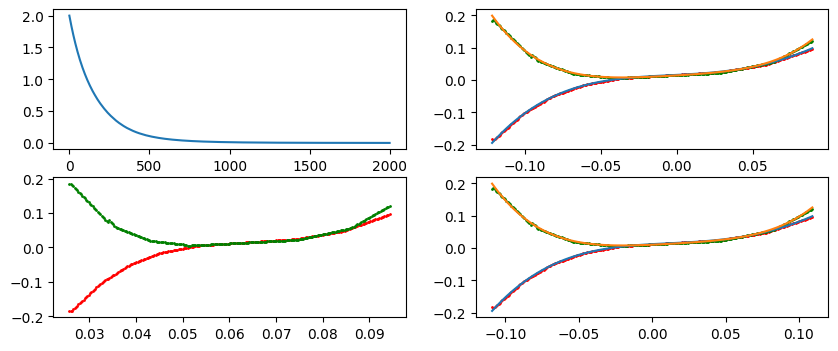

In [70]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2)

# plot loss
print ("last total_mean_loss ",total_mean_loss)
ax1.plot(losses)

# plot trained model
y = model(x)
yout = y.detach().numpy()
ax2.plot(x[:,0], ytest[:,0])
ax2.plot(x[:,0], ytest[:,1])
ax2.scatter(x[:,0], yout[:,0], color='red', s=1)
ax2.scatter(x[:,0], yout[:,1], color='green', s=1)
# Display the plot
#ax3.plot(x[:,1], ytest[:,0])
#ax3.plot(x[:,1], ytest[:,1])
ax3.scatter(x[:,1], yout[:,0], color='red', s=1)
ax3.scatter(x[:,1], yout[:,1], color='green', s=1)
ax4.plot(x[:,2], ytest[:,0])
ax4.plot(x[:,2], ytest[:,1])
ax4.scatter(x[:,2], yout[:,0], color='red', s=1)
ax4.scatter(x[:,2], yout[:,1], color='green', s=1)
plt.show()


In [153]:
# parameters
model.x.shape, model.y.shape

(torch.Size([3, 10, 2]), torch.Size([3, 10, 2]))

In [154]:
# Save graph to a file
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
graph.render("model_Segment_v1_graph")

'model_Segment_v1_graph.pdf'

In [171]:
model_params[-1]['x'][0,:,0]

tensor([-0.0281, -0.0582, -0.0154,  0.0006,  0.0423,  0.0436,  0.0800,  0.0987,
         0.1076,  0.1132])

Text(0.5, 1.0, 'Are segment x in ascending order?')

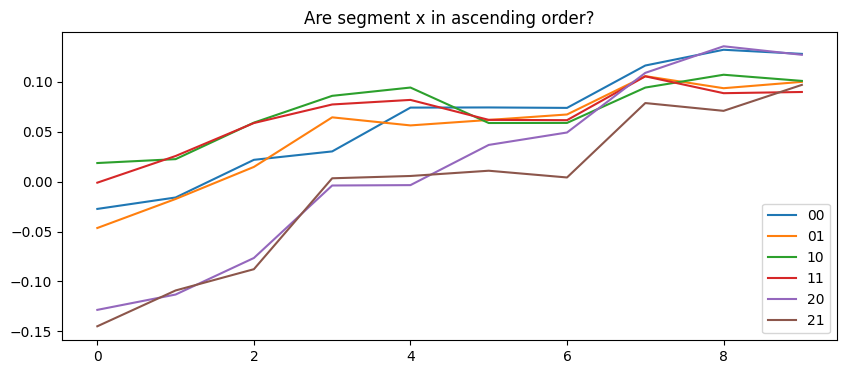

In [247]:
# Are x in ascending order?
plt.plot(np.arange(model_params[-1]['x'][0,:,0].shape[0]), model_params[-1]['x'][0,:,0], label="00")
plt.plot(np.arange(model_params[-1]['x'][0,:,1].shape[0]), model_params[-1]['x'][0,:,1], label="01")
plt.plot(np.arange(model_params[-1]['x'][1,:,0].shape[0]), model_params[-1]['x'][1,:,0], label="10")
plt.plot(np.arange(model_params[-1]['x'][1,:,1].shape[0]), model_params[-1]['x'][1,:,1], label="11")
plt.plot(np.arange(model_params[-1]['x'][2,:,0].shape[0]), model_params[-1]['x'][2,:,0], label="20")
plt.plot(np.arange(model_params[-1]['x'][2,:,1].shape[0]), model_params[-1]['x'][2,:,1], label="21")
plt.legend()
plt.title("Are segment x in ascending order?")

ValueError: only one element tensors can be converted to Python scalars

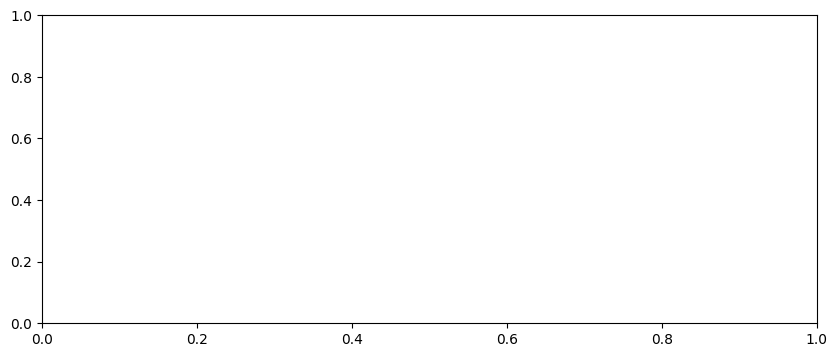

In [223]:
for seg in np.arange(model_params[-1]['x'].shape[1]-1):
 plt.plot(model_params[-1]['x'][0,seg:seg+2],model_params[-1]['y'][0,seg:seg+2],label=seg+1)    

for seg in np.arange(model_params[-1]['x'].shape[1]-1):
 plt.plot(model_params[-1]['x'][1,seg:seg+2],model_params[-1]['y'][1,seg:seg+2],label=seg+1)  
#plt.plot(model_params[-1]['x'],model_params[-1]['y']) 
plt.legend()
plt.title("How the segments connect")

# Show training as animation

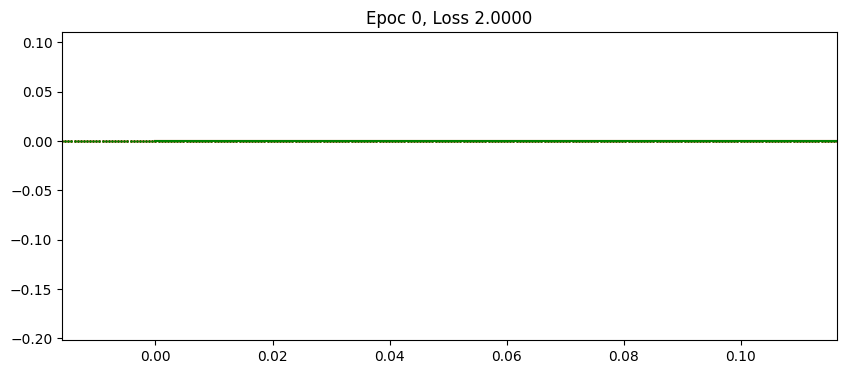

In [13]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ytest.min()*.8, ytest.max()*1.2)
ax2.plot(x, ytest[:,0,0])
ax2.plot(x, ytest[:,0,1])
scatter = ax.scatter([], [], c='r',s=1)
scatter2 = ax.scatter([], [], c='g',s=1)
a1 = ax.plot([], [], c='r', linestyle="-")
a2 = ax.plot([], [], c='g', linestyle="-")

def animate(i):
    model.load_state_dict(model_params[i])
    px = model_params[i]['x']
    py = model_params[i]['y']
    a1[0].set_data(px[0], py[0])
    a2[0].set_data(px[1], py[1])

    #alternate plot
    with torch.no_grad():
        model.eval() # be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.
        y = model(x)
    yout = y.detach().numpy()
    scatter.set_offsets(np.column_stack((x, yout[:,0,0])))
    scatter2.set_offsets(np.column_stack((x, yout[:,0,1])))
    ax.set_title(f"Epoc {i*1}, Loss {losses[10*(i)]:.4f}")
    return 

anim = FuncAnimation(fig, animate, frames=range(0,len(model_params)-1, 10))

In [14]:
from IPython.display import HTML
HTML(anim.to_jshtml())